In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorly.decomposition import parafac
from tensorly import cp_to_tensor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import tensorly as tl
tl.set_backend('pytorch')
import pickle
import os

In [2]:
df = pd.read_csv('C:/Users/genty/Hiwi-TimeSeries/dataset/DatAmount_dataset_new/1_CMX/CMX1_S_CP2.csv')
#df = df.head(1000)
target = 'CURRENT|6'
features = [
       'LOAD|1', 'LOAD|2', 'LOAD|3', 'LOAD|6',
       'ENC_POS|1', 'ENC_POS|2', 'ENC_POS|3','ENC_POS|6',
       'CTRL_DIFF2|1', 'CTRL_DIFF2|2', 'CTRL_DIFF2|3', 'CTRL_DIFF2|6',
       'TORQUE|1', 'TORQUE|2', 'TORQUE|3', 'TORQUE|6',
       'DES_POS|1', 'DES_POS|2', 'DES_POS|3', 'DES_POS|6',

       #'CURRENT|1', 'CURRENT|2', 'CURRENT|3',
        

       'CTRL_DIFF|1', 'CTRL_DIFF|2', 'CTRL_DIFF|3' ,'CTRL_DIFF|6',
       'CTRL_POS|1', 'CTRL_POS|2', 'CTRL_POS|3', 'CTRL_POS|6',
       'VEL_FFW|1', 'VEL_FFW|2','VEL_FFW|3', 'VEL_FFW|6',
       #'POWER|1','POWER|2', 'POWER|3', 'POWER|6',
       'CONT_DEV|1','CONT_DEV|2', 'CONT_DEV|3', 'CONT_DEV|6',
       #'A_DBD|0',
       'CMD_SPEED|1', 'CMD_SPEED|2', 'CMD_SPEED|3', 'CMD_SPEED|6',
       'TORQUE_FFW|1', 'TORQUE_FFW|2', 'TORQUE_FFW|3', 'TORQUE_FFW|6',
       'ENC1_POS|1', 'ENC1_POS|2', 'ENC1_POS|3','ENC1_POS|6',
       'ENC2_POS|1', 'ENC2_POS|2', 'ENC2_POS|3', 'ENC2_POS|6']
X = df[features]
y = df[[target]]


In [3]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
features_normalized = scaler_X.fit_transform(X)
target_norm = scaler_y.fit_transform(y)

tensor = features_normalized.T[np.newaxis, :, :]
tensor = tensor.astype(np.float32)
tensor = torch.tensor(tensor)

## CANDECOMP/PARAFAC (Canonical Decomposition/Parallel Factorization)

CP decomposition expresses a tensor as a sum of a finite number of rank-1 tensors.

In [ ]:
rank = 5
weights, factors = parafac(tensor, rank=rank)

reconstructed_tensor = cp_to_tensor((weights, factors))

print("Factor Matrices:")
for i, factor in enumerate(factors):
    print(f"Mode {i+1}: Shape {factor.shape}")

In [28]:
error = np.linalg.norm(tensor - reconstructed_tensor) / np.linalg.norm(tensor)
print(f"\nReconstruction Error: {error:.5f}")


Reconstruction Error: 0.42314


#### Multiple Rank values

In [46]:
ranks = [5, 10, 15, 20, 25]
reconstruction_errors = []

In [47]:
for rank in ranks:
    weights, factors = parafac(tensor, rank=rank)
    reconstructed_tensor = cp_to_tensor((weights, factors))
    error = np.linalg.norm(tensor - reconstructed_tensor) / np.linalg.norm(tensor)
    reconstruction_errors.append(error)

MemoryError: Unable to allocate 40.7 TiB for an array with shape (2364336, 2364336) and data type float64

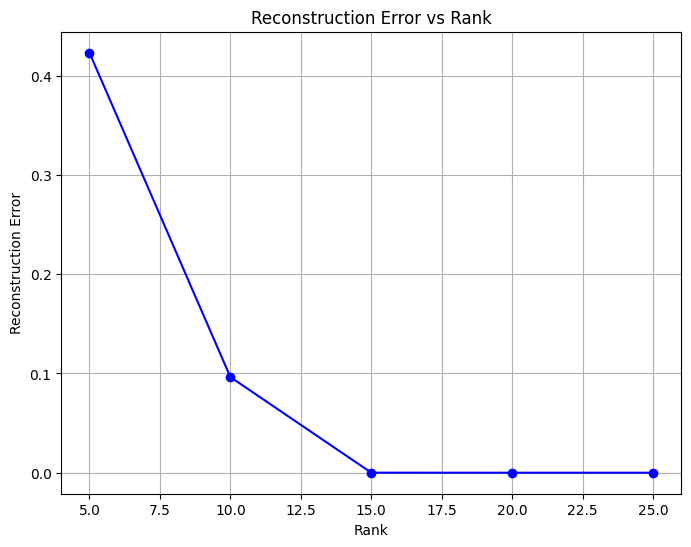

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(ranks, reconstruction_errors, marker='o', linestyle='-', color='b')
plt.title("Reconstruction Error vs Rank")
plt.xlabel("Rank")
plt.ylabel("Reconstruction Error")
plt.grid(True)
plt.show()

In [34]:
print("Rank \t Reconstruction error\n")
for i in range(5):
    print(ranks[i],"\t", reconstruction_errors[i])

Rank 	 Reconstruction error

5 	 0.4231392517049256
10 	 0.09638503903688629
15 	 5.590554182437573e-05
20 	 3.4151282348267075e-16
25 	 7.054758148540366e-14


## Tucker Decomposition

In [4]:
from tensorly.decomposition import tucker
from tensorly.metrics import RMSE
from tensorly import tucker_to_tensor

In [5]:
ranks_list = [
    [1, 5, len(df)],
    [1, 10, len(df)],
    [1, 15, len(df)],
    [1, 20, len(df)],
    [1, 25, len(df)],
    [1, 30, len(df)]
]

errors = []
for ranks in ranks_list:
    core, factors = tucker(tensor, rank=ranks)
    reconstructed_tensor = tucker_to_tensor((core, factors))
    error = RMSE(tensor, reconstructed_tensor)
    errors.append(error)
    print(f"Ranks {ranks} -> Reconstruction Error: {error}")
    with open(f"tucker_decomposition_{ranks[1]}.pkl", "wb") as f:
        pickle.dump((core, factors), f)

Ranks [1, 5, 45468] -> Reconstruction Error: 0.03954972326755524
Ranks [1, 10, 45468] -> Reconstruction Error: 0.01999189704656601
Ranks [1, 15, 45468] -> Reconstruction Error: 0.008834189735352993
Ranks [1, 20, 45468] -> Reconstruction Error: 0.0027520006988197565
Ranks [1, 25, 45468] -> Reconstruction Error: 0.0002856036298908293
Ranks [1, 30, 45468] -> Reconstruction Error: 3.8265388866420835e-06


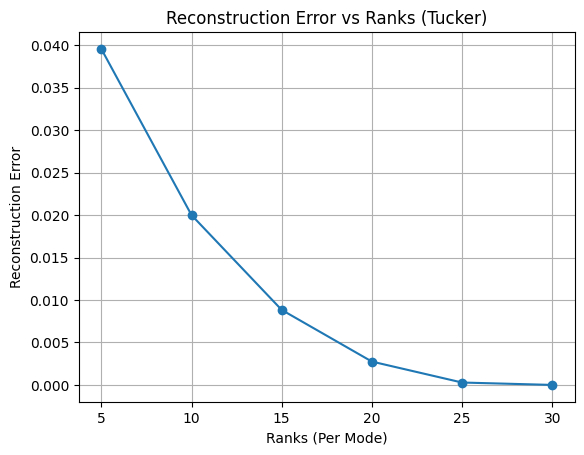

In [7]:
x_labels = [str(r[1]) for r in ranks_list]
plt.plot(x_labels, errors, marker='o')
plt.xlabel("Ranks (Per Mode)")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error vs Ranks (Tucker)")
plt.grid()
plt.show()

Tucker Decomposition Reconstruction Error: 0.0002856036298908293
Core Tensor Shape: torch.Size([1, 25, 45468])
Factor 1 Shape: torch.Size([1, 1])
Factor 2 Shape: torch.Size([52, 25])
Factor 3 Shape: torch.Size([45468, 45468])


In [8]:
factor_1, factor_2, factor_3 = factors

## LSTM

In [4]:
def create_dataset(X, y, time_step=60):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i:(i + time_step)])
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

#### Global

In [7]:
train_size = int(len(features_normalized) * 0.7)
X_train, X_test = features_normalized[:train_size], features_normalized[train_size:]
y_train, y_test = target_norm[:train_size], target_norm[train_size:]

In [8]:
time_step = 60
X_train_seq, y_train_seq = create_dataset(X_train, y_train, time_step)
X_test_seq, y_test_seq = create_dataset(X_test, y_test, time_step)

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
model = build_model(input_shape)

history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, 
                    validation_data=(X_test_seq, y_test_seq), verbose=1)

train_predict = model.predict(X_train_seq)
test_predict = model.predict(X_test_seq)

C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - loss: 0.0101 - val_loss: 0.0029
Epoch 2/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 6.1857e-05 - val_loss: 0.0018
Epoch 3/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 4.0487e-05 - val_loss: 0.0016
Epoch 4/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - loss: 4.4859e-05 - val_loss: 0.0014
Epoch 5/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 3.9383e-05 - val_loss: 9.6420e-04
Epoch 6/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 4.9901e-05 - val_loss: 6.8590e-04
Epoch 7/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 2.1249e-05 - val_loss: 5.3369e-04
Epoch 8/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 5.2303e-04 - val_loss: 3.6442e-04
Epoch 9/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 1.9689e-05 - val_loss: 7.7818e-04
Epoch 10/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 4.3872e-05 - val_loss: 4.1449e-04
Epoch 11/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - lo

In [9]:
train_predict_inv = scaler_y.inverse_transform(train_predict)
y_train_inv = scaler_y.inverse_transform(y_train_seq)
test_predict_inv = scaler_y.inverse_transform(test_predict)
y_test_inv = scaler_y.inverse_transform(y_test_seq)

In [ ]:
output_folder = 'C:/Users/genty/Hiwi-TimeSeries/output/Tucker Decomposition/'
filenamefinal = os.path.join(output_folder, f'results_TD.csv')


In [15]:
train_r2 = r2_score(y_train_inv, train_predict_inv)
test_r2 = r2_score(y_test_inv, test_predict_inv)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R2:", train_r2)
print("Test R2:", test_r2)

results = pd.DataFrame([{
        'No.of Features': '20',
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse}])

result_df = pd.concat([result_df,results], ignore_index=True)
result_df.to_csv(filenamefinal, index=False)

Train RMSE: 0.017923045525619533
Test RMSE: 0.49925315560984823
Train R2: 0.9997318262231167
Test R2: 0.8937151112885644


### Trying out three different no. of features as rank :

In [17]:
output_folder = 'C:/Users/genty/Hiwi-TimeSeries/output/Tucker Decomposition/'
result_df = pd.read_csv('C:/Users/genty/Hiwi-TimeSeries/output/Tucker Decomposition/results_TD.csv')

#result_df = pd.DataFrame(columns=['No.of Features', 'Train_R2', 'Test_R2','Train_RMSE', 'Test_RMSE'])
filenamefinal = os.path.join(output_folder, f'results_TD.csv')

In [32]:
with open("tucker_decomposition_15.pkl", "rb") as f:
    core, factors = pickle.load(f)

In [28]:
X_reduced = core.reshape(core.shape[2], -1)
train_size = int(len(X_reduced) * 0.7)
test_size = len(X_reduced) - train_size
X_train, X_test = X_reduced[:train_size], X_reduced[train_size:]
y_train, y_test = target_norm[:train_size], target_norm[train_size:]

In [29]:
time_step = 60
X_train_seq, y_train_seq = create_dataset(X_train, y_train, time_step)
X_test_seq, y_test_seq = create_dataset(X_test, y_test, time_step)

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
model = build_model(input_shape)

history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, 
                    validation_data=(X_test_seq, y_test_seq), verbose=1)

train_predict = model.predict(X_train_seq)
test_predict = model.predict(X_test_seq)

C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - loss: 0.0120 - val_loss: 0.0150
Epoch 2/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - loss: 0.0068 - val_loss: 0.0162
Epoch 3/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - loss: 0.0067 - val_loss: 0.0156
Epoch 4/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - loss: 0.0066 - val_loss: 0.0169
Epoch 5/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - loss: 0.0066 - val_loss: 0.0143
Epoch 6/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - loss: 0.0068 - val_loss: 0.0145
Epoch 7/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - loss: 0.0066 - val_loss: 0.0148
Epoch 8/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - loss: 0.0065 - val_loss: 0.0159
Epoch 9/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - loss: 0.0066 - val_loss: 0.0141
Epoch 10/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - loss: 0.0063 - val_loss: 0.0148
Epoch 11/50
993/993 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - loss: 0.0067 - val_loss: 0.0148
Epoch 12/50
993/993 ━━━━━━━━━━

In [30]:
train_predict_inv = scaler_y.inverse_transform(train_predict)
y_train_inv = scaler_y.inverse_transform(y_train_seq)
test_predict_inv = scaler_y.inverse_transform(test_predict)
y_test_inv = scaler_y.inverse_transform(y_test_seq)

In [31]:
train_r2 = r2_score(y_train_inv, train_predict_inv)
test_r2 = r2_score(y_test_inv, test_predict_inv)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R2:", train_r2)
print("Test R2:", test_r2)

results = pd.DataFrame([{
        'No.of Features': '20',
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse}])

result_df = pd.concat([result_df,results], ignore_index=True)
result_df.to_csv(filenamefinal, index=False)

Train RMSE: 1.0845077648057375
Test RMSE: 1.6403309541613627
Train R2: 0.01812088097470632
Test R2: -0.14734187841114954
